In [6]:
!unzip -q trafic_32.zip

In [1]:
%pip install lightning optuna torchmetrics[image] kornia optuna-integration torch-fidelity tensorboard matplotlib
%load_ext tensorboard

  Using cached lightning-2.2.4-py3-none-any.whl.metadata (53 kB)
  Using cached optuna-3.6.1-py3-none-any.whl.metadata (17 kB)
  Using cached kornia-0.7.2-py2.py3-none-any.whl.metadata (12 kB)
  Using cached optuna_integration-3.6.0-py3-none-any.whl.metadata (10 kB)
  Using cached torch_fidelity-0.3.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached torchmetrics-1.4.0-py3-none-any.whl.metadata (19 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl.metadata (4.7 kB)
  Using cached pytorch_lightning-2.2.4-py3-none-any.whl.metadata (21 kB)
  Using cached alembic-1.13.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached SQLAlchemy-2.0.30-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached pretty_error

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FV
import torch.optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from tqdm import tqdm
import os

import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import lightning as L
from torchmetrics import Accuracy
from lightning.pytorch.loggers import TensorBoardLogger
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import kornia.augmentation as Kaug
import kornia as K
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from PIL import Image
import os
from torchmetrics.image.fid import FrechetInceptionDistance
import optuna

from utils import show
from data import get_sanity_dataset, ClassSampler, DiffiusionDataModule, PreProcess
from blocks import UNet, UpBlock, DownBlock, ResidualBlock

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = int(os.cpu_count() / 2)
CLASSES_NO = 43
NUM_STEPS = 1000
plt.rcParams["savefig.bbox"] = 'tight'

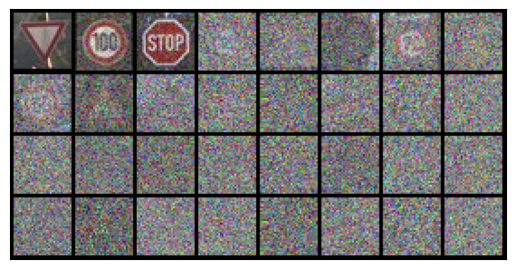

In [2]:
import math
def sinusoidal_embedding(x):
    log_min_freq = math.log(1.0)
    log_max_freq = math.log(1000.0)
    num_frequencies = 16
    frequencies = torch.exp(torch.linspace(log_min_freq, log_max_freq, num_frequencies, dtype=torch.float32)).to(DEVICE)
    angular_speeds = 2.0 * math.pi * frequencies
    sin_embeddings = torch.sin(angular_speeds.unsqueeze(1) * x).to(DEVICE)
    cos_embeddings = torch.cos(angular_speeds.unsqueeze(1) * x).to(DEVICE)
    embeddings = torch.cat([sin_embeddings, cos_embeddings], dim=1)
    return embeddings.view(-1, 32, 1, 1)

def cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = torch.tensor(0.00, device=DEVICE)
    max_signal_rate = torch.tensor(0.99, device=DEVICE)
    start_angle = torch.acos(max_signal_rate).to(DEVICE)
    end_angle = torch.acos(min_signal_rate).to(DEVICE)
    angles = start_angle+diffusion_times*(end_angle-start_angle)
    signal_rates = torch.cos(angles).to(DEVICE)
    noise_rates = torch.sin(angles).to(DEVICE)
    return noise_rates, signal_rates

class LinearNoiseScheduler:
    def __init__(self, num_steps, device, beta_start=1e-4, beta_end=2e-2):
        
        self.device = device
        
        self.num_steps = num_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.num_steps, dtype=torch.float32, device=self.device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        
    def get_alpha_bar(self, t):
        return self.alpha_bars[t]
    
    def get_variance(self, t):
        return self.betas[t]
    
    def get_rates(self, t):
        alpha_bar_t = self.get_alpha_bar(t)
        return (
            torch.sqrt(alpha_bar_t).to(self.device).unsqueeze(1).unsqueeze(2).unsqueeze(3),
            torch.sqrt(1 - alpha_bar_t).to(self.device).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        )
    
    def add_noise(self, x, noise, t):
        alpha_bar_t = self.get_alpha_bar(t)
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        return (sqrt_alpha_bar_t * x + sqrt_one_minus_alpha_bar_t * noise), sqrt_alpha_bar_t, sqrt_one_minus_alpha_bar_t

def validate_linear_scheduler():
    def normalize(tensor):
        min_val = tensor.view(tensor.size(0), -1).min(dim=1, keepdim=True)[0]
        max_val = tensor.view(tensor.size(0), -1).max(dim=1, keepdim=True)[0]
        return (tensor - min_val[:, :, None, None]) / (max_val[:, :, None, None] - min_val[:, :, None, None] + 1e-8)

    dt, kr = get_sanity_dataset()
    x, y = next(iter(dt))
    x, y = x.to(DEVICE), y.to(DEVICE)
    # show(x.cpu(), False)
    x = kr(x)
    num_steps = 1000
    scheduler = LinearNoiseScheduler(num_steps, DEVICE, 1e-4, 5e-3)
    t = torch.linspace(0, num_steps-1, x.shape[0], dtype=torch.int32)
    noise = torch.randn_like(x)
    x_noisy, sr, nr = scheduler.add_noise(x, noise, t)
    
    mean = torch.tensor((0.5, 0.5, 0.5), device=DEVICE).view(1, 3, 1, 1)
    std = torch.tensor((0.5, 0.5, 0.5), device=DEVICE).view(1, 3, 1, 1)
    show(torch.cat([normalize(x_noisy), normalize(nr*noise)], dim=0).cpu(), False)
validate_linear_scheduler()




### Noise schedule validate

In [130]:
def normalize(tensor):
        min_val = tensor.min()
        max_val = tensor.max()
        tensor = (tensor - min_val) / (max_val - min_val + 1e-8)
        # tensor = torch.clamp(tensor, 0, 1)
        return tensor
normalize(torch.tensor(0).view(1, 1, 1, 1))

tensor([[[[0.]]]])

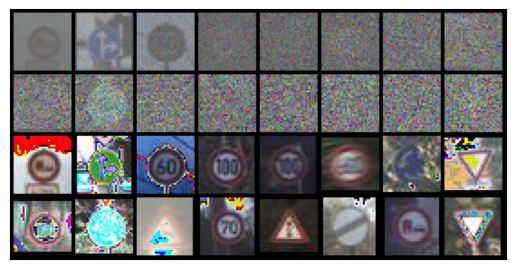

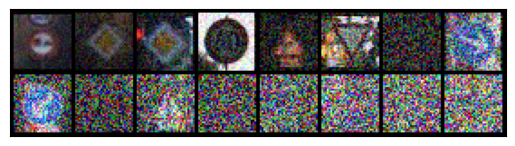

In [7]:
dt, kr = get_sanity_dataset()
x, y = next(iter(dt))
x, y = x.to(DEVICE), y.to(DEVICE)
x = kr(x)

diff_times = torch.linspace(0.0, 1.0, x.shape[0], device=DEVICE).view(-1, 1, 1, 1)
noise_amount, signal_amount = cosine_diffusion_schedule(diff_times)

noise = torch.rand_like(x, device=DEVICE)*2-1

x = x*signal_amount + noise * noise_amount
x = torch.clamp(x, -1, 1)
show(x.cpu())

In [13]:
t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
scheduler = LinearNoiseScheduler(NUM_STEPS, DEVICE)
sinusoidal_embedding(scheduler.get_variance(t)).expand(-1, -1, 32, 32).shape

torch.Size([16, 32, 32, 32])

100%|██████████| 16/16 [00:02<00:00,  7.49it/s]


Validation Loss after epoch 1: 0.0544210656080395


100%|██████████| 16/16 [00:00<00:00, 21.82it/s]


Validation Loss after epoch 2: 0.04110972338821739


100%|██████████| 16/16 [00:00<00:00, 21.54it/s]


Validation Loss after epoch 3: 0.03626695682760328


100%|██████████| 16/16 [00:00<00:00, 21.20it/s]


Validation Loss after epoch 4: 0.032728063175454736


100%|██████████| 16/16 [00:00<00:00, 21.56it/s]


Validation Loss after epoch 5: 0.03178112662862986


100%|██████████| 16/16 [00:00<00:00, 19.98it/s]


Validation Loss after epoch 6: 0.029782600700855255


100%|██████████| 16/16 [00:00<00:00, 21.41it/s]


Validation Loss after epoch 7: 0.03039573458954692


100%|██████████| 16/16 [00:00<00:00, 20.20it/s]


Validation Loss after epoch 8: 0.026678143651224673


100%|██████████| 16/16 [00:00<00:00, 21.32it/s]


Validation Loss after epoch 9: 0.026827919064089656


100%|██████████| 16/16 [00:00<00:00, 22.10it/s]


Validation Loss after epoch 10: 0.02966167568229139


100%|██████████| 16/16 [00:00<00:00, 21.21it/s]


Validation Loss after epoch 11: 0.027439296478405595


100%|██████████| 16/16 [00:00<00:00, 22.09it/s]


Validation Loss after epoch 12: 0.026777322636917233


100%|██████████| 16/16 [00:00<00:00, 22.04it/s]


Validation Loss after epoch 13: 0.02830872987397015


100%|██████████| 16/16 [00:00<00:00, 21.92it/s]


Validation Loss after epoch 14: 0.02771003858651966


100%|██████████| 16/16 [00:00<00:00, 21.07it/s]


Validation Loss after epoch 15: 0.026102198753505945


100%|██████████| 16/16 [00:00<00:00, 21.52it/s]


Validation Loss after epoch 16: 0.02463017962872982


100%|██████████| 16/16 [00:00<00:00, 21.07it/s]


Validation Loss after epoch 17: 0.02395380730740726


100%|██████████| 16/16 [00:00<00:00, 21.15it/s]


Validation Loss after epoch 18: 0.02536702761426568


100%|██████████| 16/16 [00:00<00:00, 19.43it/s]


Validation Loss after epoch 19: 0.02578337350860238


100%|██████████| 16/16 [00:00<00:00, 18.22it/s]


Validation Loss after epoch 20: 0.02452981029637158


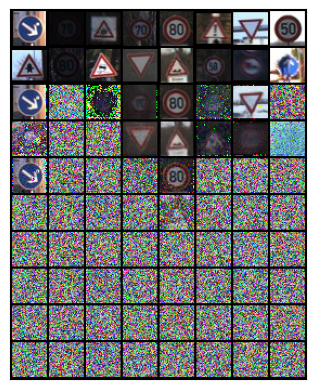

In [4]:
from blocks import UNet, UpBlock, DownBlock, ResidualBlock
def validate_unet():
    dt, kr = get_sanity_dataset(256)
    dv, kr = get_sanity_dataset(256, 'val')
    model = UNet(CLASSES_NO, DEVICE, sinusoidal_embedding).to(DEVICE)
    scheduler = LinearNoiseScheduler(NUM_STEPS, DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for ep in range(20):
        i = 0
        for x, y in tqdm(dt):
            x, y = x.to(DEVICE), y.to(DEVICE)
            x = kr(x)
            optimizer.zero_grad()
            t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
            noise = torch.randn_like(x, device=DEVICE)
            noised = scheduler.add_noise(x, noise, t)[0]
            # noised = torch.clamp(noised, -1, 1)
            logits = model(noised, scheduler.get_variance(t), y)
            loss = criterion(noise, logits)
            loss.backward()
            optimizer.step()
            i+=1
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x, y in tqdm(dv):
                x, y = x.to(DEVICE), y.to(DEVICE)
                x = kr(x)
                
                t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
                noise = torch.randn_like(x, device=DEVICE)
                noised = scheduler.add_noise(x, noise, t)[0]
                # noised = torch.clamp(noised, -1, 1)
                logits = model(noised, scheduler.get_variance(t), y)
                loss = criterion(noise, logits)
                val_losses.append(loss.item())
            avg_val_loss = sum(val_losses) / len(val_losses)
            print(f"Validation Loss after epoch {ep+1}: {avg_val_loss}")
    model.eval()
    with torch.no_grad():
        x, y = next(iter(dt))
        x, y = x.to(DEVICE), y.to(DEVICE)
        x = kr(x)
        
        t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
        noise = torch.randn_like(x, device=DEVICE)
        noised, signal_rates, noise_rates = scheduler.add_noise(x, noise, t)
        # noised = torch.clamp(noised, -1, 1)
        logits = model(noised, scheduler.get_variance(t), y)
        loss = criterion(noise, logits)
        pred_images = (noised - (noise_rates) * logits) / signal_rates
        show(torch.cat([
            x.cpu()[:16],
            pred_images.cpu()[:16],
            noised.cpu()[:16],
            noise.cpu()[:16],
            logits.cpu()[:16]
        ], dim=0))
    return model
unet_model = validate_unet()

### UNet validate

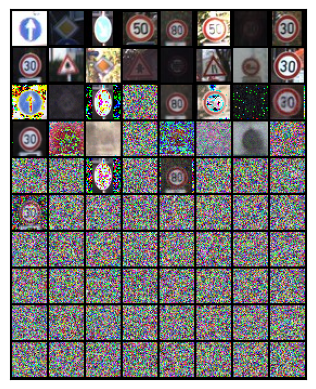

In [7]:
scheduler = LinearNoiseScheduler(NUM_STEPS, DEVICE)
dt, kr = get_sanity_dataset(256)

unet_model.eval()
with torch.no_grad():
    x, y = next(iter(dt))
    x, y = x.to(DEVICE), y.to(DEVICE)
    x = kr(x)
    
    t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
    noise = torch.randn_like(x, device=DEVICE)
    noised, signal_rates, noise_rates = scheduler.add_noise(x, noise, t)
    # noised = torch.clamp(noised, -1, 1)
    logits = unet_model(noised, scheduler.get_variance(t), y)
    pred_images = (noised - noise_rates * logits) / signal_rates
    show(torch.cat([
        x.cpu()[:16],
        pred_images.cpu()[:16],
        noised.cpu()[:16],
        noise.cpu()[:16],
        logits.cpu()[:16]
    ], dim=0))

In [3]:
from blocks import UNet

class DiffusionModel(L.LightningModule):
    def __init__(self, sampler, model=None, transform=None, trial=None, diff_scheduler=cosine_diffusion_schedule,learning_rate=1e-3, class_emb_size=8, transformed_class_emb=32):
        super(DiffusionModel, self).__init__()
        self.save_hyperparameters()
        
        self.network: UNet = UNet(CLASSES_NO, DEVICE, sinusoidal_embedding,class_emb_size=self.hparams.class_emb_size, latent_class_emb_size=self.hparams.transformed_class_emb).to(DEVICE) if model is None else model
        self.sampler = sampler
        self.transform = transform if transform is not None else transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        # self.ema_network = deepcopy(unet)
        self.cosine_diffusion_schedule = diff_scheduler
        self.trial = trial
        self.scheduler = LinearNoiseScheduler(NUM_STEPS, DEVICE)

    def forward(self, noisy_images, noise_rates, class_labels):
        return self.network(noisy_images, noise_rates, class_labels)

    def denoise(self, noisy_images, noise_rates, signal_rates, class_labels):
        pred_noises = self(noisy_images, noise_rates, class_labels)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps, class_labels):
        num_images = initial_noise.size(0)
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        def normalize(tensor):
            min_val = tensor.view(tensor.size(0), -1).min(dim=1, keepdim=True)[0]
            max_val = tensor.view(tensor.size(0), -1).max(dim=1, keepdim=True)[0]
            return (tensor - min_val[:, :, None, None]) / (max_val[:, :, None, None] - min_val[:, :, None, None] + 1e-8)
        for step in range(diffusion_steps):
            diffusion_times = torch.ones((num_images, 1, 1, 1), device=initial_noise.device) - step * step_size
            signal_rates, noise_rates = self.scheduler.get_rates(NUM_STEPS-step)
            pred_noises, pred_images = self.denoise(current_images, noise_rates, signal_rates, class_labels)
            next_signal_rates, next_noise_rates = self.cosine_diffusion_schedule(NUM_STEPS-(step+1))
            current_images = next_signal_rates * pred_images + next_noise_rates * pred_noises
        return normalize(pred_images)

    def denormalize(self, images):
        mean = torch.tensor((0.5, 0.5, 0.5), device=DEVICE).view(1, 3, 1, 1)  # Reshape to [1, C, 1, 1] for broadcasting
        var = torch.tensor((0.5, 0.5, 0.5), device=DEVICE).view(1, 3, 1, 1)
        images = mean + images * var
        return images

    def generate(self, num_images, diffusion_steps):
        initial_noise = torch.randn(num_images, 3, 32, 32, device=DEVICE)
        class_labels = self.sampler.sample(initial_noise)
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps, class_labels)
        generated_images = self.denormalize(generated_images)
        return generated_images
    
    def corrupt(self, images):
        noise = torch.randn_like(images)
        t = torch.randint(0, NUM_STEPS-1, (images.shape[0],), device=DEVICE)
        noised, signal_rates, noise_rates = scheduler.add_noise(images, noise, t)
        return noise, noised, noise_rates, signal_rates

    def training_step(self, batch, batch_idx):
        images, class_labels = batch
        images, class_labels = images.to(DEVICE), class_labels.to(DEVICE)
        
        if self.transform is not None:
            images = self.transform(images.to(DEVICE))
        noises, noised_imgs, noise_rate, signal_rate = self.corrupt(images)

        pred_noises, pred_images = self.denoise(noised_imgs, noise_rate, signal_rate, class_labels)
        loss = F.mse_loss(noises, pred_noises)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, class_labels = batch
        if self.transform is not None:
            images = self.transform(images.to(DEVICE))

        noise = torch.randn_like(images)
        t = torch.randint(0, NUM_STEPS-1, (images.shape[0],), device=DEVICE)
        noised, signal_rates, noise_rates = scheduler.add_noise(images, noise, t)

        pred_noises, pred_images = self.denoise(noised, noise_rates, signal_rates, class_labels)
        loss = F.mse_loss(noise, pred_noises)
        
        self.log('val_loss', loss)
        def normalize(tensor):
            tensor = self.denormalize(tensor)
            min_val = tensor.view(tensor.size(0), -1).min(dim=1, keepdim=True)[0]
            max_val = tensor.view(tensor.size(0), -1).max(dim=1, keepdim=True)[0]
            return (tensor - min_val[:, :, None, None]) / (max_val[:, :, None, None] - min_val[:, :, None, None] + 1e-8)
        self.logger.experiment.add_image("rectonstructed_images", make_grid(normalize(pred_images[:64])), self.current_epoch)

        if self.trial is not None:
            self.trial.report(loss, self.current_epoch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.network.parameters(), lr=self.hparams.learning_rate)
        return optimizer

### Validate Diffusion

In [ ]:
def validate_diff():
    dt, _ = get_sanity_dataset(256)
    sampler = ClassSampler(ImageFolder('trafic_32'), DEVICE)

    model = DiffusionModel(sampler).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for _ in range(10):
        i = 0
        model.train()
        for x, y in tqdm(dt):
            optimizer.zero_grad()
            
            images, class_labels = x.to(DEVICE), y.to(DEVICE)
            images = model.transform(images.to(DEVICE))
            noises, noised_imgs, noise_rate, signal_rate = model.corrupt(images)

            pred_noises, pred_images = model.denoise(noised_imgs, noise_rate, signal_rate, class_labels)
            loss = F.mse_loss(noises, pred_noises)
            loss.backward()
            optimizer.step()
            i+=1
        model.eval()
        with torch.no_grad():
            x, y = next(iter(dt))
            x, y = x.to(DEVICE), y.to(DEVICE)
            x = model.transform(x)
            noises, noised_imgs, noise_rate, signal_rate = model.corrupt(x)
            pred_noises, pred_images = model.denoise(noised_imgs, noise_rate, signal_rate, y)
            show(pred_noises.cpu()[:16])
            show(noises.cpu()[:16])
            show(pred_images.cpu()[:16])
            show(x.cpu()[:16])
    return model
df_model = validate_diff()

### validate diffusion model denoise

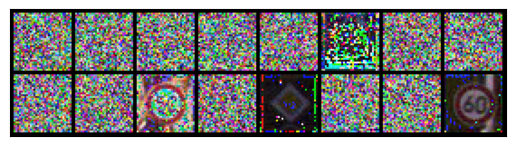

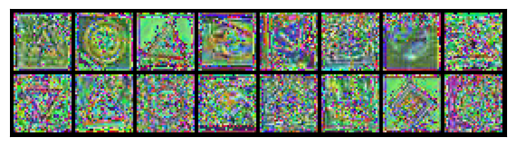

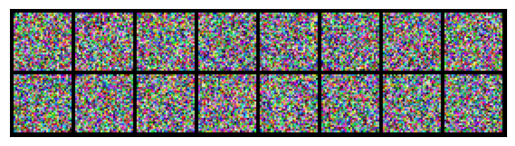

In [21]:
dt, kr = get_sanity_dataset()
x, y = next(iter(dt))
x, y = x.to(DEVICE), y.to(DEVICE)
x = kr(x)

t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
noise = torch.randn_like(x, device=DEVICE)
noised, signal_rates, noise_rates = scheduler.add_noise(x, noise, t)

pred_n, pred_img = df_model.denoise(x, noise_rates, signal_rates, y)
pred_img = df_model.denormalize(pred_img)
show(pred_img.cpu(), False)
show(pred_n.cpu())
show(noise.cpu())


### validate model generate

In [97]:
step_size = 1.0 / 10
diffusion_times = torch.ones((1, 1, 1, 1), device=DEVICE)*0.99 - 0 * step_size

In [ ]:
df_model.eval()
steps = 10
step_size = 1.0 / steps
dt, kr = get_sanity_dataset()
x, y = next(iter(dt))
x, y = x.to(DEVICE), y.to(DEVICE)
x = kr(x)
with torch.no_grad():
    current_images = torch.randn(1, 3, 32, 32, device=DEVICE)
    class_labels = df_model.sampler.sample(current_images)
    diffusion_times = torch.ones((current_images.shape[0], 1, 1, 1), device=DEVICE)*0.99 - 0 * step_size
    noise_rates, signal_rates = df_model.cosine_diffusion_schedule(diffusion_times)
    for _ in range(1):
        pred_noises, pred_images = df_model.denoise(current_images, noise_rates, signal_rates, y)
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = df_model.cosine_diffusion_schedule(next_diffusion_times)
        current_images = next_signal_rates * pred_images + next_noise_rates * pred_noises
        current_images = torch.clamp(current_images, -1, 1)
        noise_rates, signal_rates = next_noise_rates, next_signal_rates
    show(pred_images.cpu())

In [144]:
logger = TensorBoardLogger("logs", name="dev", version="dev_8")
sampler = ClassSampler(ImageFolder('trafic_32'), DEVICE)
model = DiffusionModel(sampler).to(DEVICE)
trainer = L.Trainer(max_epochs=100, 
                        accelerator="gpu", 
                        callbacks=[L.pytorch.callbacks.EarlyStopping(monitor='val_loss', patience=7, strict=False, verbose=False, mode='min')],
                        logger=logger
                        )
trainer.fit(model, DiffiusionDataModule(), ckpt_path="/home/Stable-diffusion/logs/dev/dev_8/checkpoints/epoch=25-step=3588.ckpt")
# trainer.fit(model, DiffiusionDataModule())


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /home/Stable-diffusion/logs/dev/dev_8/checkpoints/epoch=25-step=3588.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | network   | UNet      | 5.8 M 
1 | transform | Normalize | 0     
----------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.120    Total estimated model params size (MB)
Restored all states from the checkpoint at /home/Stable-diffusion/logs/dev/dev_8/checkpoints/epoch=25-step=3588.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [27]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 34111), started 0:00:18 ago. (Use '!kill 34111' to kill it.)

In [4]:
sampler = ClassSampler(ImageFolder('trafic_32'), DEVICE)
model = DiffusionModel.load_from_checkpoint("/home/Stable-diffusion/logs/dev/dev_8/checkpoints/epoch=51-step=7176.ckpt", sampler=sampler).to(DEVICE)

In [10]:
# generator = DiffusionModel.load_from_checkpoint("/home/mszawerd/Learn/ium/gen/epoch37-step5244.ckpt", sampler=sampler, tranform=KorniaAugmentationHVFlip_Jitter())
def reverse_diffusion(self, initial_noise, diffusion_steps, class_labels):
    num_images = initial_noise.size(0)
    step_size = 1.0 / diffusion_steps
    current_images = initial_noise
    def normalize(tensor):
        min_val = tensor.view(tensor.size(0), -1).min(dim=1, keepdim=True)[0]
        max_val = tensor.view(tensor.size(0), -1).max(dim=1, keepdim=True)[0]
        return (tensor - min_val[:, :, None, None]) / (max_val[:, :, None, None] - min_val[:, :, None, None] + 1e-8)
    for step in range(diffusion_steps):
        diffusion_times = torch.ones((num_images, 1, 1, 1), device=initial_noise.device) - step * step_size
        signal_rates, noise_rates = self.scheduler.get_rates(NUM_STEPS-step)
        pred_noises, pred_images = self.denoise(current_images, noise_rates, signal_rates, class_labels)
        next_signal_rates, next_noise_rates = self.cosine_diffusion_schedule(NUM_STEPS-(step+1))
        current_images = next_signal_rates * pred_images + next_noise_rates * pred_noises
    return normalize(pred_images)

def denormalize(self, images):
    mean = torch.tensor((0.5, 0.5, 0.5), device=DEVICE).view(1, 3, 1, 1)  # Reshape to [1, C, 1, 1] for broadcasting
    var = torch.tensor((0.5, 0.5, 0.5), device=DEVICE).view(1, 3, 1, 1)
    images = mean + images * var
    return images

def generate(self, num_images, diffusion_steps):
    initial_noise = torch.randn(num_images, 3, 32, 32, device=DEVICE)
    class_labels = self.sampler.sample(initial_noise)
    generated_images = self.reverse_diffusion(initial_noise, diffusion_steps, class_labels)
    generated_images = self.denormalize(generated_images)
    return generated_images

# with torch.no_grad():
#     num_images = 1
    # current_images = torch.randn(num_images, 3, 32, 32, device=DEVICE)
#     class_labels = model.sampler.sample(current_images)
#     for step in range(NUM_STEPS):
            # diffusion_times = NUM_STEPS-torch.ones((num_images, 1, 1, 1), device=current_images.device).long()*step
#             signal_rates, noise_rates = model.scheduler.get_rates(diffusion_times)
#             pred_noises, pred_images = model.denoise(current_images, noise_rates, signal_rates, class_labels)
#             current_images = model.scheduler.add_noise(pred_images, pred_noises, diffusion_times-1)
# show(pred_images)
step = 0
num_images=1
current_images = torch.randn(num_images, 3, 32, 32, device=DEVICE)
st = torch.ones((num_images, 1, 1, 1), device=current_images.device).long()*step
diffusion_times = NUM_STEPS- st
# signal_rates, noise_rates = model.scheduler.get_rates(diffusion_times)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
